<a href="https://colab.research.google.com/github/mbmarcin/ml_/blob/main/wine_models_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.feature_selection import RFE
from scipy.stats import randint
from sklearn import tree
import graphviz


In [57]:
wines = pd.read_csv('winequality-all.csv')
wines.columns
wines['color'] = wines['color'].astype('category')
wines['color'] = wines['color'].cat.codes.values

In [58]:
print("Distribution of target variable in 'wines' data set:")
wines.color.value_counts(normalize=True)

Distribution of target variable in 'wines' data set:


1    0.744549
0    0.255451
Name: color, dtype: float64

In [59]:
y = wines.color
wines.drop('color', axis = 1, inplace = True)

In [60]:
x_tr, x_te, y_tr, y_te = train_test_split(wines, y, test_size = 0.2, random_state = 5062018, stratify = y)

In [61]:
print("Distribution of datasets in both data set after splitting. \n \n")
print('Training data set:')
print(y_tr.value_counts(normalize=True))
print('')
print('Test data set:')
print(y_te.value_counts(normalize=True))

Distribution of datasets in both data set after splitting. 
 

Training data set:
1    0.744596
0    0.255404
Name: color, dtype: float64

Test data set:
1    0.744361
0    0.255639
Name: color, dtype: float64


In [62]:


def cv_and_score_model(model, x, y, prints):
    """Model scorer. Calculates: average gini score, average recall and stability.

    Parameters:
    -----------
    model: sklearn predictive model, model that will be scored
    
    x : pandas DataFrame, set of x-features

    y : pandas Series, target feature
    """
    
    cv_auc = cross_val_score(model, x, y, cv = 10, scoring = 'roc_auc')
    cv_recall = cross_val_score(model, x, y, cv = 10, scoring = 'recall')
    
    # Calculate Gini score based on AUC.
    cv_gini = (cv_auc * 2) - 1 
    
    # Printing results.
    if prints:
        print('Average Gini: {}.'.format(np.mean(cv_gini).round(3)))
        print('Average recall: {}.'.format(np.mean(cv_recall).round(3)))
        print('Stability: {}%'.format((100 - np.std(cv_gini)*100/cv_gini.mean()).round(3)))
    return cv_gini

def test_model(model, features, plots):
    """Model scorer. Calculates: average gini score, average recall and stability.

    Parameters:
    -----------
    model: sklearn predictive model, model that will be tested
    
    plots : bool, decission whether to print plots
    """
    
    model.fit(x_tr[features], y_tr)
    pred_prob = model.predict_proba(x_te[features])
    y_pred = model.predict(x_te[features])
    
    # convert 2D list to list of probabilities
    prob = []
    for n in pred_prob:
        prob.append(n[1])
    gini_score = (2* roc_auc_score(y_te, prob))-1
    
    # calculate FPR and TPR
    fpr, tpr, thresholds = roc_curve(y_te, prob)
    
    print('Gini score: {}.'.format(gini_score.round(3)))
    print('Recall score: {}.'.format(recall_score(y_te, y_pred).round(3)))
    
    if plots == True:
        # ROC CURVE
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='blue',
                 lw=lw, label='ROC curve (area under curve = %0.3f)' % roc_auc_score(y_te, prob))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

        # DENSITY PLOT
        pre = pd.DataFrame(prob, columns = ['prob'])
        pre['pred_class'] = 1
        pre.loc[pre.prob < 0.5,'pred_class'] = 0
        pre['real_class'] = list(y_te)

        sns.distplot(pre[pre.real_class == 0]['prob'], label = 'negatives').set(title = 'Density plot', xlabel = 'probability')
        sns.distplot(pre[pre.real_class == 1]['prob'], label = 'positives').set(title = 'Density plot', xlabel = 'probability')
        plt.legend()
        plt.show()


In [63]:
model_1 = DecisionTreeClassifier()
gini = cv_and_score_model(model_1, x_tr, y_tr, True)

Average Gini: 0.951.
Average recall: 0.986.
Stability: 98.016%


In [64]:
test_model(model_1, x_tr.columns, False)

Gini score: 0.922.
Recall score: 0.985.


In [65]:
def forward_selection(model, x, y):
    """Forward selection method.

    Parameters:
    -----------
    model : sklearn model, that will be used in features selection 
    
    x : pandas DataFrame with all possible predictors
    
    y : pandas Series with target variable

    Returns:
    --------
    best_features: "optimal" set of features selected by forward selection evaluated by Gini score
    """
    
    
    remaining = set(x.columns)
    best_features = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            gini_score = cv_and_score_model(model, x[best_features+[candidate]], y_tr, False) 
            scores_with_candidates.append((gini_score.mean(), candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            best_features.append(best_candidate)
            current_score = best_new_score
    return best_features

def backward_selection(model, x, y):
    """Backward selection method.

    Parameters:
    -----------
    model : sklearn model, that will be used in features selection 
    
    x : pandas DataFrame with all possible predictors
    
    y : pandas Series with target variable

    Returns:
    --------
    best_features: "optimal" set of features selected by backward selection evaluated by Gini score
    """
    
    
    remaining = set(x.columns)
    features_to_remove = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            gini_score = cv_and_score_model(model, x[list(remaining)].drop([candidate], axis = 1), y_tr, False) 
            scores_with_candidates.append((gini_score.mean(), candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            features_to_remove.append(best_candidate)
            current_score = best_new_score
    best_features = list(x.drop(features_to_remove, axis = 1).columns)
    return best_features


In [66]:
# model 2

model_2 = DecisionTreeClassifier()
model_2.fit(x_tr, y_tr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [67]:
#Feature importances - using decission tree model.

pd.Series(model_2.feature_importances_, index = x_tr.columns).sort_values(ascending = False)

total.sulfur.dioxide    0.677634
chlorides               0.212401
density                 0.048577
pH                      0.019272
residual.sugar          0.013017
volatile.acidity        0.010004
sulphates               0.007990
citric.acid             0.004648
alcohol                 0.003716
fixed.acidity           0.002122
free.sulfur.dioxide     0.000618
response                0.000000
dtype: float64

In [68]:
selected_features_fs = forward_selection(model_2, x_tr, y_tr)
print('Number of selected features: {}.'.format(len(selected_features_fs)))
print('Selected features: {}.'.format(list(selected_features_fs)))

Number of selected features: 7.
Selected features: ['total.sulfur.dioxide', 'chlorides', 'density', 'residual.sugar', 'citric.acid', 'alcohol', 'free.sulfur.dioxide'].


In [69]:
gini = cv_and_score_model(model_2, x_tr[selected_features_fs], y_tr, True)

Average Gini: 0.951.
Average recall: 0.987.
Stability: 98.643%


In [70]:
selected_features_bs = backward_selection(model_2, x_tr, y_tr)
print('Number of selected features: {}.'.format(len(selected_features_bs)))
print('Selected features: {}.'.format(list(selected_features_bs)))

Number of selected features: 11.
Selected features: ['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'response'].


In [71]:
gini = cv_and_score_model(model_2, x_tr[selected_features_bs], y_tr, True)

Average Gini: 0.953.
Average recall: 0.986.
Stability: 98.27%


In [72]:
for n in np.arange(1, 13, 1):
    selector = RFE(model_2, n, 1)
    print('=================================')
    print('Model with {} features.'.format(n))
    print('=================================')
    cv_and_score_model(model_2, x_tr.iloc[:,selector.fit(x_tr, y_tr).support_], y_tr, True)
    print('')

Model with 1 features.
Average Gini: 0.879.
Average recall: 0.962.
Stability: 97.764%

Model with 2 features.
Average Gini: 0.91.
Average recall: 0.975.
Stability: 97.827%

Model with 3 features.
Average Gini: 0.939.
Average recall: 0.98.
Stability: 98.197%

Model with 4 features.
Average Gini: 0.945.
Average recall: 0.985.
Stability: 97.953%

Model with 5 features.
Average Gini: 0.945.
Average recall: 0.988.
Stability: 98.235%

Model with 6 features.
Average Gini: 0.948.
Average recall: 0.988.
Stability: 97.406%

Model with 7 features.
Average Gini: 0.95.
Average recall: 0.988.
Stability: 98.261%

Model with 8 features.
Average Gini: 0.952.
Average recall: 0.99.
Stability: 98.261%

Model with 9 features.
Average Gini: 0.948.
Average recall: 0.989.
Stability: 98.081%

Model with 10 features.
Average Gini: 0.943.
Average recall: 0.987.
Stability: 97.585%

Model with 11 features.
Average Gini: 0.948.
Average recall: 0.987.
Stability: 97.726%

Model with 12 features.
Average Gini: 0.948.


In [73]:
selector = RFE(model_2, 8, 1)
selected_features_rfe = x_tr.iloc[:,selector.fit(x_tr, y_tr).support_].columns
print('Number of selected features: {}.'.format(len(selected_features_rfe)))
print('Selected features: {}.'.format(list(selected_features_rfe)))

Number of selected features: 8.
Selected features: ['volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates'].


In [74]:
gini = cv_and_score_model(model_2, x_tr[selected_features_rfe], y_tr, True)

Average Gini: 0.949.
Average recall: 0.988.
Stability: 97.757%


In [75]:
#GridSearchCV.

parameters = {'criterion':('entropy', 'gini'), 
              'splitter':('best','random'), 
              'max_depth':np.arange(1, 6), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10)
grid_search.fit(x_tr[selected_features_bs], y_tr)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('entropy', 'gini'),
                  

In [76]:
best_parameters_gs = grid_search.best_params_
print('Best parameters choosed by GridSearchCV: {}'.format(best_parameters_gs))

Best parameters choosed by GridSearchCV: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'splitter': 'best'}


In [77]:
model_3 = DecisionTreeClassifier(**best_parameters_gs)
gini = cv_and_score_model(model_3, x_tr[selected_features_bs], y_tr, True)

Average Gini: 0.972.
Average recall: 0.989.
Stability: 97.589%


In [78]:
#RandomizedSearchCV.

params_rs = {'criterion':('entropy', 'gini'),
'splitter':('best','random'),
'max_depth':randint(1,6),
'min_samples_split':randint(3,8),
'min_samples_leaf':randint(1,5)}

rs = RandomizedSearchCV(model_3, cv = 10, n_iter = 20, param_distributions = params_rs)
rs.fit(x_tr[selected_features_bs], y_tr)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=5,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=3,
                                                    min_samples_split=8,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
         

In [79]:
best_parameters_rs = rs.best_params_
print('Best parameters choosed by RandomizedSearchCV: {}'.format(best_parameters_rs))

Best parameters choosed by RandomizedSearchCV: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}


In [80]:
model_3 = DecisionTreeClassifier(**best_parameters_rs)
gini = cv_and_score_model(model_3, x_tr[selected_features_bs], y_tr, True)

Average Gini: 0.971.
Average recall: 0.989.
Stability: 97.745%


In [82]:
model_3.fit(x_tr[selected_features_bs], y_tr)
pd.Series(model_3.feature_importances_, index = selected_features_bs).sort_values(ascending = False)

chlorides               0.599358
total.sulfur.dioxide    0.292640
density                 0.033542
fixed.acidity           0.028199
volatile.acidity        0.026655
alcohol                 0.008063
sulphates               0.006461
pH                      0.005082
response                0.000000
residual.sugar          0.000000
citric.acid             0.000000
dtype: float64

In [86]:
# model 4
selected_features_bs_2 = backward_selection(model_3, x_tr[selected_features_bs], y_tr)
gini = cv_and_score_model(model_3, x_tr[selected_features_bs_2], y_tr, True)

Average Gini: 0.979.
Average recall: 0.99.
Stability: 99.202%


In [87]:
selected_features_fs_2 = forward_selection(model_3, x_tr[selected_features_bs], y_tr)
gini = cv_and_score_model(model_3, x_tr[selected_features_fs_2], y_tr, True)

Average Gini: 0.982.
Average recall: 0.989.
Stability: 98.864%


In [91]:
gini = test_model(model_3, selected_features_fs_2, False)

Gini score: 0.968.
Recall score: 0.985.


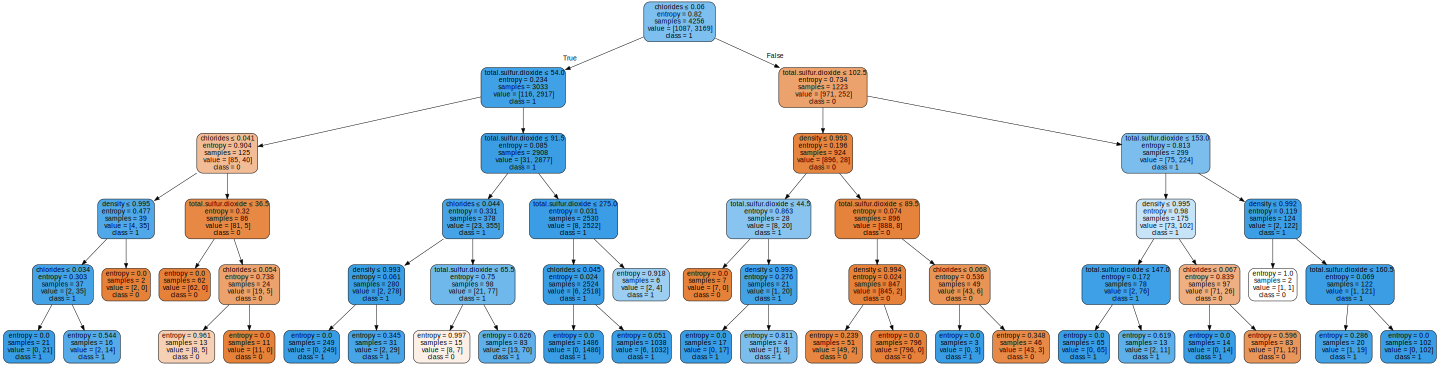

In [95]:
dot_data = tree.export_graphviz(model_3, out_file=None, 
                         feature_names=selected_features_fs_2,  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
out = dot_data[0:14] + 'ranksep=.75; size = "20,30";' + dot_data[14:]
graph = graphviz.Source(out)
graph

In [97]:
samples = x_te[selected_features_fs_2].sample(5).sort_index()
samples

,chlorides,total.sulfur.dioxide,density
908,0.070,26.0,0.99358
1277,0.070,14.0,0.99562
1343,0.053,27.0,0.99362
4104,0.055,157.0,0.99384
4700,0.054,143.0,0.99287


In [99]:
y_te[y_te.index.isin(samples.index)].sort_index(inplace = True)
pd.DataFrame({'true_y' : y_te[y_te.index.isin(samples.index)], 'predicted_y' : model_3.predict(samples)}, index = samples.index)

,true_y,predicted_y
908,0,0
1277,0,0
1343,0,0
4104,1,1
4700,1,1


https://mateuszgrzyb.pl/historia-pewnego-procesu-rekrutacyjnego/
